In [1]:
! pip install datasets 
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.0 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 212 kB 44.3 MB/s 
     |████████████████████████████████| 140 kB 38.8 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
     |████████████████████████████████| 144 kB 51.6 MB/s 
     |████████████████████████████████| 271 kB 62.1 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
ERROR: pip's depend

In [2]:
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from transformers import TFBertModel
from transformers import TFAutoModel
from tensorflow.keras import *
from tensorflow.keras import layers
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp '/content/drive/MyDrive/Question2_Data.zip' .

In [9]:
!unzip Question2_Data.zip

Archive:  Question2_Data.zip
   creating: Question2_Data/
  inflating: __MACOSX/._Question2_Data  
  inflating: Question2_Data/train.xlsx  
  inflating: __MACOSX/Question2_Data/._train.xlsx  
  inflating: Question2_Data/valid.xlsx  
  inflating: __MACOSX/Question2_Data/._valid.xlsx  
  inflating: Question2_Data/test.xlsx  
  inflating: __MACOSX/Question2_Data/._test.xlsx  


In [14]:
class DataLoader:
  def __init__(self,tokenizer):
    self.tokenizer = tokenizer
    self.train_df = pd.read_excel('Question2_Data/train.xlsx')
    self.test_df = pd.read_excel('Question2_Data/test.xlsx')
    self.valid_df = pd.read_excel('Question2_Data/valid.xlsx')
    self.label_encoder = LabelEncoder()

  def split_data(self,column):
    x_train,y_train = self.train_df[column].values,to_categorical(self.label_encoder.fit_transform(self.train_df['category'].values),dtype = 'int32')
    x_test,y_test = self.test_df[column].values,to_categorical(self.label_encoder.transform(self.test_df['category'].values),dtype = 'int32')
    x_valid,y_valid = self.valid_df[column].values,to_categorical(self.label_encoder.transform(self.valid_df['category'].values),dtype = 'int32')
    return x_train,y_train,x_test,y_test,x_valid,y_valid

  def generate_bert_input(self,data,max_sequence_length=128):
    ids = []
    attn_masks = []
    for i,text in tqdm(enumerate(data)):
        tokenized_text = self.tokenizer.encode_plus(
            text,
            max_length = max_sequence_length,
            truncation = True,
            padding = 'max_length',
            add_special_tokens = True,
            return_tensors = 'tf'
        )
        ids.append(tokenized_text.input_ids[0])
        attn_masks.append(tokenized_text.attention_mask[0])
    return [np.array(ids),np.array(attn_masks)]


In [17]:
class Bert:

  def __init__(self,model_address):
    self.model_address = model_address
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_address)
    try:
      self.bert = TFAutoModel.from_pretrained(self.model_address)
    except:
      self.bert = TFAutoModel.from_pretrained(self.model_address,from_pt=True)
    self.data_loader = DataLoader(self.tokenizer)

  def createBERTModel(self,max_length=128):
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
  
    self.bert.trainable = True
    bert_output = self.bert(input_ids, attention_mask=attention_masks)
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
    output = layers.Dense(1024,activation="relu")(dropout)
    output = tf.keras.layers.Dense(3, activation="softmax")(output)
    self.model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks], outputs=output
    )
    #self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    print(self.model.summary())
    return self.model

  def train_model(self):
    self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    x_train,y_train,x_test,y_test,x_valid,y_valid = self.data_loader.split_data('source')
    train_data = self.data_loader.generate_bert_input(x_train)
    valid_data = self.data_loader.generate_bert_input(x_valid)
    self.history = self.model.fit(train_data, y_train,validation_data=(valid_data,y_valid),epochs=10, batch_size = 32)

  def plot_accuracy(self):
    plt.plot(self.history.history['accuracy'],label='train')
    plt.plot(self.history.history['val_accuracy'],label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

  def eval_model(self):
    x_train,y_train,x_test,y_test,x_valid,y_valid = self.data_loader.split_data('targets')
    test_data = self.data_loader.generate_bert_input(x_test)
    predicted_y = self.model.predict(test_data)
    number_label_mapping = {0: 'bible', 1:'mizan',2:'quran'}
    y_test_conv = [number_label_mapping[np.argmax(val)] for val in y_test]
    predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
    print('Classification report:')
    print(classification_report(y_test_conv, predicted_y_conv))
    print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
    print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
    print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
    print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
    print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
    print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
    print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
    print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
    print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
    print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))
    y_auc = [np.argmax(val) for val in y_test]
    print('AUC:', roc_auc_score(y_auc,predicted_y, multi_class='ovr'))

In [18]:
xlm_model = Bert('xlm-roberta-base')
xlm_model.createBERTModel()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tfxlm_roberta_model_2 (TFXLMRo  TFBaseModelOutputWi  278043648  ['input_ids[0][0]',              
 bertaModel)                    thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [19]:
xlm_model.train_model()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
394/394 [==============================] - 383s 935ms/step - loss: 0.2358 - accuracy: 0.9095 - val_loss: 0.0911 - val_accuracy: 0.9681
Epoch 2/10
394/394 [==============================] - 365s 927ms/step - loss: 0.0710 - accuracy: 0.9773 - val_loss: 0.0739 - val_accuracy: 0.9744
Epoch 3/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.0898 - val_accuracy: 0.9748
Epoch 4/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0311 - accuracy: 0.9896 - val_loss: 0.0965 - val_accuracy: 0.9804
Epoch 5/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0301 - accuracy: 0.9898 - val_loss: 0.0794 - val_accuracy: 0.9819
Epoch 6/10
394/394 [==============================] - 365s 925ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0970 - val_accuracy: 0.9781
Epoch 7/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.0803 -

0it [00:00, ?it/s]

Classification report:
              precision    recall  f1-score   support

       bible       0.81      0.24      0.37       900
       mizan       0.54      1.00      0.70       900
       quran       0.78      0.67      0.72       900

    accuracy                           0.63      2700
   macro avg       0.71      0.63      0.60      2700
weighted avg       0.71      0.63      0.60      2700

Accuracy: 0.6344444444444445
F1 (Micro): 0.6344444444444445
F1 (Macro): 0.5969503599198224
F1 (Weighted): 0.5969503599198224
Recall (Micro): 0.6344444444444445
Recall (Macro): 0.6344444444444445
Recall (Weighted): 0.6344444444444445
Precision (Micro): 0.6344444444444445
Precision (Macro): 0.7104101946437393
Precision (Weighted): 0.7104101946437393
AUC: 0.8305431069958847


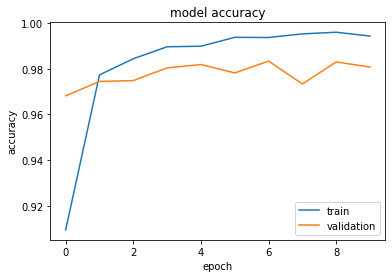

In [21]:
xlm_model.eval_model()
xlm_model.plot_accuracy()